In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
import os
import strax
import json
import patrick_stylez as ps

In [11]:
ctx = straxbra.XebraContext(register=[straxbra.plugins.DAQReader],
                            config={'do_breaks' : False})
all_gains = {}

In [12]:
def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus
    

def fit_fcn(x, h_bgd, mu_bgd, sigma_bgd, h_spe, mu_spe, sigma_spe, h_dpe, h_tpe):
        background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
        spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
        dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
        tpe =           h_tpe             * np.exp(-(x - 3 * mu_spe) ** 2    / (3 * 2 * sigma_spe ** 2))
        fit_function = background + spe + dpe + tpe
        return fit_function
    
# def fit_fcn_bot(x, h_bgd, mu_bgd, sigma_bgd,h_uae, mu_uae, sigma_uae, h_spe, mu_spe, sigma_spe, h_dpe):
#         background =    h_bgd             * np.exp(-(x - mu_bgd) ** 2        / (2 * sigma_bgd ** 2))
#         uae =           h_uae             * np.exp(-(x - mu_uae) ** 2        / (2 * sigma_uae ** 2))
#         spe =           h_spe             * np.exp(-(x - mu_spe) ** 2        / (2 * sigma_spe ** 2))
#         dpe =           h_dpe             * np.exp(-(x - 2 * mu_spe) ** 2    / (2 * 2 * sigma_spe ** 2))
#         fit_function_2 = background + uae + spe + dpe
#         return fit_function_2
    



def PlotForRun(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
#     raw = ctx.get_array(run, 'raw_records')
    window_low = 40
    window_high = 65
    
    
    gains = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pcov' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }

    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) *10 
    adc_to_pe = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19)
#     gain_list = []
#     error_list = []
    for ch in range(8):
#         if (ch==0 or ch==1 or ch == 6):
#                bin_high =320
#         if (ch == 2 or ch == 4):
#             bin_high = 260
#         if (ch == 3 or ch == 7):
#             bin_high = 620
#         if ch == 5:
#             bin_high = 200 
        
    
    
    
        bin_high = 410
        num_bins = int((bin_high+40)/3)
        bins = np.linspace(-40,bin_high,num_bins)
        bin_widths = bins[1:] - bins[:-1]
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        
        
        
        
        
        ax = axs[ch//3][ch%3]
        n, _ = np.histogram(raw['data'][raw['channel'] == ch,window_low:window_high].sum(axis=1), bins=bins)
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        n = n/bin_widths
        gains['bin_centers'].append(bin_centers.tolist())
        gains['histogram'].append(n.tolist())       
        mu_bkg_index = np.argmax(n)  
        mu_bkg = bin_centers[mu_bkg_index]
        h_bkg = n[mu_bkg_index]  
        sigma_bkg = 0
        for i in n[mu_bkg_index:]:
            if i < h_bkg * 0.5:
                
                FWHM = np.abs(
                    bin_centers[np.where(n[mu_bkg_index:] ==i) + mu_bkg_index] - bin_centers[np.where(n[mu_bkg_index:] == h_bkg)+ mu_bkg_index])*2
                sigma_bkg +=FWHM / (2 * np.sqrt(2 * np.log(2)))
                sigma_bkg = sigma_bkg[0][0]
                #print(n[mu_bgd_index:].index(h_bgd))
                break
        
        
        
        
        if ch == 0:
#             mu_spe = 22.6
            mu_spe = 21.7
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.99*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.01*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
                print(1./popt[4])
                print('PMT gain is: ', popt[4]* adc_to_pe)
                print('PMT gain error: ',perr[4]* adc_to_pe)
            except Exception as e:
                print('CH%i failed\n' % ch)

                
                
                
                
        elif ch == 1: 
            mu_spe = 54.0
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5] 
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
                print('PMT gain is: ', popt[4]* adc_to_pe)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
                
                
                
                
        elif ch == 2:  
            mu_spe = 76.1
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
        elif ch == 3:  
            mu_spe = 112.2
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
        elif ch == 4:  
            mu_spe = 69.3
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
        elif ch == 5:  
            mu_spe = 21.1
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
        elif ch == 6:  
            mu_spe = 37.6
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)
                
                
        elif ch == 7:  
            mu_spe = 78.7
            p0 = [h_bkg, mu_bkg, sigma_bkg,     100, mu_spe, sigma_bkg,         10, 5]
            bounds = ((0, -50, 0.5*sigma_bkg,                    0, 0.9*mu_spe, 0, 0,0          ), 
              (np.inf, np.inf, 1.5*sigma_bkg,                 0.1*h_bkg, 1.1*mu_spe, np.inf,0.1*h_bkg, 0.01*h_bkg       ))

            try:

                popt, pcov = curve_fit(fit_fcn, bin_centers, n,p0=p0, bounds=bounds, sigma=sigma, maxfev = 100000)
                perr = np.sqrt(np.diag(pcov))
                print(popt[4])
                ax.plot(bin_centers, n, c='k', alpha = 0.5)
                ax.plot(bin_centers, (fit_fcn(bin_centers, *popt)), 'b-') 
                ax.plot(bin_centers, (gaus(bin_centers, popt[0], popt[1], popt[2])), 'g--', label='bkg peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[3], popt[4], popt[5])), 'y--', label='spe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[6], 2*popt[4], popt[5])), 'm--', label='dpe peak')
                ax.plot(bin_centers, (gaus(bin_centers, popt[7], 3*popt[4], popt[5])), 'c--', label='tpe peak')
                gains['popt'].append(popt.tolist())
                gains['pcov'].append(pcov.tolist())
                gains['adc_to_pe'].append(1./popt[4])
                gains['gain'].append(popt[4]*adc_to_e)
            except Exception as e:
                print('CH%i failed\n' % ch)

        ax.set_ylim([1,None])
#        ax.legend()

        ax.set_yscale('log')
    plt.show()
#     print(gains)
    return gains

In [5]:
#(2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) *10 

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
21.916999999999994
0.0456266824839166
PMT gain is:  3757605.3919417127
PMT gain error:  4109708.8576995614
51.95949868398618
PMT gain is:  8908303.710249342
68.49000000000001
100.98000000000002
68.57169741811079
23.209999999983495
41.36
75.60299389354836


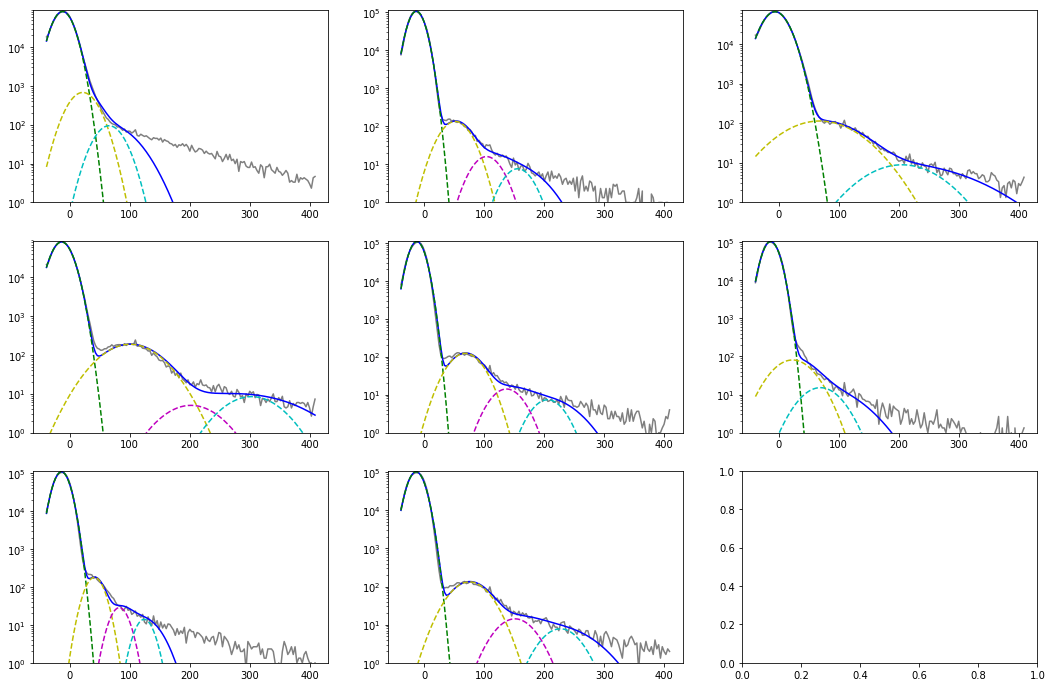

In [14]:
run = '00216'
raw = ctx.get_array(run, 'raw_records')
gaindoc = PlotForRun(ctx,run)

In [7]:
print(gaindoc['adc_to_pe'])

[0.0456266824839166, 0.019245759203373493, 0.01460067163089502, 0.009902951079421666, 0.014583276156962761, 0.0430848772081306, 0.024177949709864605, 0.013226989415366734]


In [8]:
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#   #  client['xebra_daq']['pmt_gains'].update_one({'run' : },{'$set' : gaindoc})
#      client['xebra_daq']['pmt_gains'].insert_one(gaindoc)

In [9]:
# with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
#      client['xebra_daq']['pmt_gains'].insert_one(gaindoc)